In [1]:
# modules that you are likely to use

import xarray as xr
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np

import xesmf  # used for regridding

# if not already available install the `tephigram` package with
# `pip install tephigram`
import tephigram

%matplotlib inline

# Cloud locations from brightness temperature

For this section you will use the following skills:

1. loading NetCDF files using `xarray.open_dataset` (or multiple files at once with `xarray.open_mfdataset`)
2. plotting scalar fields with geographical information such as coastlines and borders in a specific geographic projection using `cartopy`
3. doing data-range selection (in space and time) with `xarray.Dataset.sel`
4. doing line (`plt.plot`) and contour plots (`plt.contour`) and adding labels (`plt.text`)

From the paper:

> At 1300 UTC, 31 July 2006 the parent storm is clearly visible in the satellite imagery (marked with a ‘P’); it then tracked westwards during the afternoon, reaching 3°W by 1800 UTC. The location of the daughter storm is illustrated on Figure 6(c) and (d) (marked with a ‘D’); it initiated over relatively dry soil, with a wet patch of soil immediately to the southeast and an additional wet patch approximately 80 km to the northwest (shown in more detail in Figure 3; Taylor et al., 2010). By late afternoon (Figure 6(d)) the daughter storm had increased in size and most of the subsequent convection in the system occurred over wet soil (Taylor et al., 2010).

<img src='../figures/figure-6.jpg' width=500 />

**Figure 6: The top panels show soil moisture in the uppermost layer at 1300 UTC, 31 July for (a) the satellite observations, (e) the control simulation and
(i) the ASSIM simulation. Note the difference in units between the observed and simulated soil moisture. Panels (b)–(d) show observed soil moisture
(contour at 5%) and MSG brightness temperatures**

In [2]:
ds_ir = xr.open_mfdataset('../data/GPM_MERGIR/*.nc4')
ds_ir

<xarray.Dataset>
Dimensions:  (lat: 3298, lon: 9896, time: 192)
Coordinates:
  * lon      (lon) float32 -179.98181 -179.94543 -179.90906 -179.87268 ...
  * lat      (lat) float32 -59.981808 -59.945423 -59.909035 -59.87265 ...
  * time     (time) datetime64[ns] 2006-07-30 2006-07-30T00:30:00.000013312 ...
Data variables:
    Tb       (time, lat, lon) float32 dask.array<shape=(192, 3298, 9896), chunksize=(2, 3298, 9896)>
Attributes:
    BeginDate:       2006-07-30
    BeginTime:       00:00:00.000Z
    EndDate:         2006-07-30
    EndTime:         00:59:59.999Z
    FileHeader:      StartGranuleDateTime=2006-07-30T00:00:00.000Z;\nStopGran...
    InputPointer:    merg_2006073000_4km-pixel
    title:           NCEP/CPC 4km Global (60N - 60S) IR Dataset
    ProductionTime:  2017-11-11T10:08:04.000Z

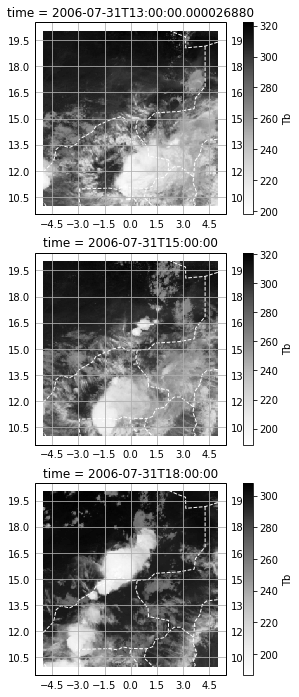

In [3]:
times = [
    '2006-07-31 13:00',
    '2006-07-31 15:00',
    '2006-07-31 18:00'
]

window = dict(lat=slice(10, 20), lon=slice(-5, 5))

plt.figure(figsize=(6, 12))
for n, t in enumerate(times):
    ax = plt.subplot(3, 1, n+1, projection=ccrs.PlateCarree())
    ds_ir.sel(**window).sel(time=t, method='nearest').Tb.plot(rasterized=True, ax=ax, cmap='Greys')
    ax.set_aspect(1)
    ax.coastlines(color='white')
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', edgecolor='white')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False

# Soil moisture and wind vectors


For this section you will use the following skills:

1. loading NetCDF files using `xarray.open_dataset` (or multiple files at once with `xarray.open_mfdataset`)
2. plotting scalar fields with geographical information such as coastlines and borders in a specific geographic projection using `cartopy`
3. doing data-range selection (in space and time) with `xarray.Dataset.sel`
4. doing *filled* contour plots (`plt.contourf`)


From the paper:

> The initiation times and locations of the new convective cells in relation to the soil‐moisture heterogeneity is shown in more detail in Figure 7. The times were diagnosed subjectively using hourly plots of model rainfall rate. When the rainfall rate associated with a particular cell became continuous over two intervals of 1 h, and prevailed over a region with a radius greater than ∼20 km, an initialization time and location was noted on the plot. The preference for initiation over soil‐moisture gradients is similar in the two runs, but slightly less widespread in the ASSIM run, which is more consistent with the observations.

> In Figure 7 the initiation point of the main daughter storm is marked by ‘14’ at 14.8°N, 2°E in both the control and ASSIM simulations. The location of the parent storm at 1200 UTC is shown on the plots by the thick white contour at 12–14°N, 1–3°E. The daughter storm initiates over a region of dry soil, which is in the same location as the significant boundary‐layer convergence cause by the confluence of the moist southerly monsoon winds with the westerly winds to the south of the Saharan heat low.

<img src='../figures/figure-7.jpg' width=500 />

** Figure 7: Soil moisture and 925 hPa wind vectors at 1200 UTC, 31 July 2006 from (a) the control run and (b) the ASSIM run at 0600 UTC 31 July 2006. The thick white contour indicates the position of the parent storm at 1200 UTC. The white boxes indicate the locations of the first initiations and contain the times in UTC of the first significant rainfall at each location. The black line shows the diagonal transect.  **

The Met Office Unified Model outputs its data on a *rotated pole* and so we need to transform from this grid to a regular lat/lon grid. In addition we regrid the data below so that the data will be on a lat/lon coordinate aligned grid

In [6]:
def get_transform(da):
    """
    Get the correct transform for Unified Model data.
    """
    return ccrs.RotatedPole(pole_longitude=da.north_pole[0],     
                         pole_latitude=da.north_pole[1],
                         globe=ccrs.Globe(semimajor_axis=6370000,
                                         semiminor_axis=6370000))

def regrid_um_data(da, d_deg, method):
    """
    Regrids Unified Model data in `da` to grid-aligned lat/lon grid with grid resolution `d_deg`
    NOTE: if `d_deg` is smaller than the grid resolution a warning will be issued
    """
    trnsfm = get_transform(da)
    pts = ccrs.PlateCarree().transform_points(trnsfm, *np.meshgrid(da.x, da.y))

    lon = pts[...,0]
    lat = pts[...,1]

    old_grid = xr.Dataset(coords=dict(x=da.x, y=da.y))
    # we transpose lat and lon because xESMF prefers data to be fortran-ordered (instead of c-ordered)
    old_grid['lat'] = (('y', 'x'), np.ascontiguousarray(lat))
    old_grid['lon'] = (('y', 'x'), np.ascontiguousarray(lon))
    
    d_lat = d_lon = d_deg
    d_lat_min = np.diff(lat).max()
    d_lon_min = np.diff(lon).max()
    
    if d_lat < d_lat_min or d_lon < d_lon_min:
        raise Exception("Requested resolution `{}` is smaller than the coarsest resolution "
                        "in the input data (`{}` and `{}`)".format(d_deg, d_lat_min, d_lon_min))
    
    lat_new = np.arange(lat.min(), lat.max(), d_lat)
    lon_new = np.arange(lon.min(), lon.max(), d_lon)

    new_grid = xr.Dataset(coords=dict(lat=lat_new, lon=lon_new))
    
    regridder = xesmf.Regridder(ds_in=old_grid, ds_out=new_grid, method=method, reuse_weights=True)
    
    da_regridded = regridder(da)
    # copy over attributes
    da_regridded.attrs.update(da.attrs)
    # but remove the rotate grid info
    del(da_regridded.attrs['north_pole'])
    # xarray 
    
    return da_regridded

In [7]:
!cat ../data/UM/README.md

# B223 case Unified Model simulation

notes compiled by Leif Denby in 2018

## File descriptions

Data organised into different files for different variables:

- `xgifha_pa###.nc`: QCF, QCL on p-levels - `xgifha_pb###.nc`: p, p_1 on
  hybrid-levels

- `xgifha_pc###.nc`: u, v, dz_dt,temp on p-levels

- `xgifha_pd###.nc`: theta, q on hybrid-levels

- `xgifha_pf###.nc`: x-wind, y-wind, dz_dt on hybrid-levels

- `xgifha_pg###.nc`: temp, blt, solar, etc on surface and top-of-atmosphere

- `xgifha_ph###.nc`: surface fields?


In [19]:
ds = xr.open_mfdataset('../data/UM/b223_case/xgifha_pb005.nc')
ds

<xarray.Dataset>
Dimensions:      (hybrid_ht: 50, hybrid_ht_1: 50, t: 12, x: 1110, y: 776)
Coordinates:
  * x            (x) float32 339.0 339.03598 339.072 339.108 339.14398 ...
  * y            (y) float32 -11.0 -10.964001 -10.928 -10.892 -10.856 ...
  * hybrid_ht    (hybrid_ht) float32 2.4999995 13.333332 33.333332 60.0 ...
  * t            (t) datetime64[ns] 2006-07-31T11:05:00.002288818 ...
  * hybrid_ht_1  (hybrid_ht_1) float32 5.0 21.666664 45.0 75.0 111.66668 ...
Data variables:
    p            (t, hybrid_ht, y, x) float32 dask.array<shape=(12, 50, 776, 1110), chunksize=(12, 50, 776, 1110)>
    p_1          (t, hybrid_ht_1, y, x) float32 dask.array<shape=(12, 50, 776, 1110), chunksize=(12, 50, 776, 1110)>
Attributes:
    history:  Tue Oct 25 18:12:04 BST 2011 - CONVSH V1.91 16-February-2006

In [61]:
ds_surface = xr.open_mfdataset('../data/UM/b223_case/xgifha_pd005.nc')
ds_surface

<xarray.Dataset>
Dimensions:    (hybrid_ht: 50, t: 12, x: 1110, y: 776)
Coordinates:
  * x          (x) float32 339.0 339.03598 339.072 339.108 339.14398 339.18 ...
  * y          (y) float32 -11.0 -10.964001 -10.928 -10.892 -10.856 ...
  * hybrid_ht  (hybrid_ht) float32 5.0 21.666664 45.0 75.0 111.66668 155.0 ...
  * t          (t) datetime64[ns] 2006-07-31T11:05:00.002288818 ...
Data variables:
    theta      (t, hybrid_ht, y, x) float32 dask.array<shape=(12, 50, 776, 1110), chunksize=(12, 50, 776, 1110)>
    q          (t, hybrid_ht, y, x) float32 dask.array<shape=(12, 50, 776, 1110), chunksize=(12, 50, 776, 1110)>
Attributes:
    history:  Wed Oct 26 16:27:23 BST 2011 - CONVSH V1.91 16-February-2006

In [9]:
# we chunk on the `p` (vertical) coordinate so we don't have to load everything in memory at one time
ds_plevels = xr.open_mfdataset('../data/UM/b223_case/xgifha_pc005.nc', chunks=dict(p=1))
ds_plevels
# let's extract the level we need already, save computation and memory
ds_950hPa = ds_plevels.sel(p=950., method='nearest')

In [10]:
da_sm = regrid_um_data(ds_surface.sm, d_deg=0.04, method='bilinear')
da_sm = da_sm.rename(dict(t_1='time')).squeeze()

Reuse existing file: bilinear_776x1110_716x1078.nc


In [11]:
da_u = regrid_um_data(ds_950hPa.u, d_deg=0.04, method='bilinear')
da_u = da_u.rename(dict(t='time')).squeeze()
da_v = regrid_um_data(ds_950hPa.v, d_deg=0.04, method='bilinear')
da_v = da_v.rename(dict(t='time')).squeeze()

Reuse existing file: bilinear_775x1110_715x1078.nc
Reuse existing file: bilinear_775x1110_715x1078.nc


In [12]:
# transect endpoints
p0 = [17, 0]  # (lat, lon)
p1 = [11, 5]  # (lat, lon)

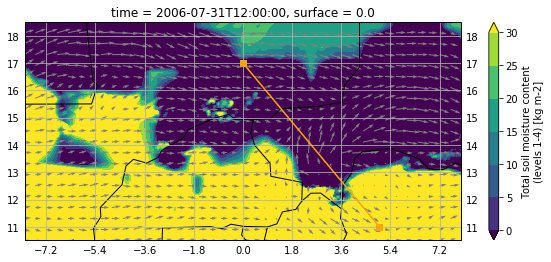

In [14]:
plt.figure(figsize=(10,4))
ax = plt.subplot(projection=ccrs.PlateCarree())

sel_domain = dict(lat=slice(10.5, 18.5), lon=slice(-8, 8))
sel_time = dict(time="2006-07-31 12:00", method='nearest')

da_sm_ = da_sm.sel(**sel_domain).sel(**sel_time).squeeze()
da_sm_.plot.contourf(ax=ax, vmin=0.0, vmax=30.)

n_skip = 10 # number of points to skip for each quiver
sel_domain_steps = dict(lat=slice(None,None,n_skip), lon=slice(None, None, n_skip))
da_u_ = da_u.sel(**sel_domain).sel(**sel_time).sel(**sel_domain_steps).squeeze()
da_v_ = da_v.sel(**sel_domain).sel(**sel_time).sel(**sel_domain_steps).squeeze()

plt.quiver(da_u_.lon, da_u_.lat, da_u_, da_v_, color='grey')

gl = ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
gl.xlabels_top = False

plt.plot([p0[1], p1[1]], [p0[0], p1[0]], linestyle='-', marker='s', color='orange')

# Tephigram


From the paper:

> The differences in boundary‐layer structure over the wet and dry soil are illustrated by a tephigram of model diagnostics at 1100 UTC, 31 July (Figure 8). Over the dry soil (at 15°N, 1.7°E, solid lines) the boundary layer is deeper (extends to 850 hPa, compared with 925 hPa) and ∼6°C warmer than over the wet soil (16°N, 1°E, dashed lines). Contrary to what would be expected, the lower atmosphere (925 to 650 hPa) is more humid over the dry soil than over the wet soil. This increase in low‐level humidity is caused by the monsoon flow, which transports moist air from the south. The monsoon flow does not reach the location of the wet soil (16°N, 1°E in Figure 8) and thus the humidity at that location is lower. The higher temperatures (and to a much lesser extent the humidities) over the dry soil cause the CAPE to be approximately double that of the wet soil (1074 J kg−1, compared with 529 J kg−1). CIN is also much lower over the dry soil (16 J kg−1, compared with 163 J kg−1). The low CIN, high CAPE combination of the monsoon air over the dry soil provides suitable conditions for the development of deep convection. It was this thermodynamic profile and the uplift provided by the convergence zone that initiated the convection that later developed into the daughter storm.

<img src='../figures/figure-8.jpg' width=500 />

** Figure 8: Tephigram of model diagnostics from the control simulation at 1100 UTC, 31 July 2006 over dry soil at 15.0°N, 1.7°E (solid lines) and over the adjacent wet soil at 16.0°N, 1°E (dashed lines). Convective available potential energy values are 1074 J kg−1 over the dry soil and 529 J kg−1 over the wet soil. Convective inhibition values are 16 J kg−1 over the dry soil and 163 J kg−1 over the wet soil. **

In [5]:
# (we'll use the ERA-Interim data here, the procedure is the same with any other dataset)
#
# 1. Load in the dataset using `xarray.open_dataset` or `xarray.open_mfdataset`
#    We will be using the "ERA-Interim" reanalysis simulations, look in `data/ERA-Interim`
ds_ei_plevels = xr.open_mfdataset('../data/ERA-Interim/ei_model_levels.nc')
ds_ei_sfc = xr.open_mfdataset('../data/ERA-Interim/ei_surface.nc')
ds_ei = xr.merge([ds_ei_plevels, ds_ei_sfc])

In [6]:
ds_ = ds_ei.sel(latitude=15., longitude=1.7, time='2006-07-31 11:00', method='nearest')
ds_

<xarray.Dataset>
Dimensions:    (level: 27)
Coordinates:
    longitude  float32 1.5
    latitude   float32 15.0
  * level      (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
    time       datetime64[ns] 2006-07-31T12:00:00
Data variables:
    w          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    r          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    vo         (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    q          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    z          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    t          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    u          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    v          (level) float32 dask.array<shape=(27,), chunksize=(27,)>
    sp         float32 dask.array<shape=(), chunksize=()>
    msl        float32 dask.array<shape=(), chunksize=()>
    tcw        float32 dask.array<shape=(), chunk

In [7]:
# if not already available install the `tephigram` package with
# `pip install tephigram`

In [8]:
from tephigram import Tephigram

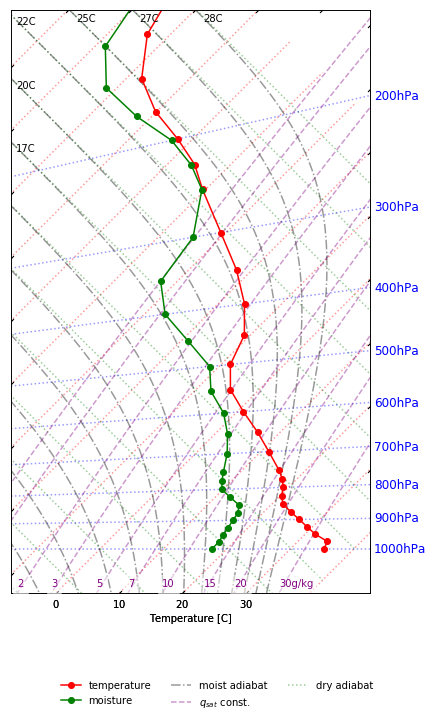

In [9]:
tphi = Tephigram()
tphi.plot_temp(P=ds_.level, T=ds_.t-273.15)
tphi.plot_RH(P=ds_.level, T=ds_.t-273.15, RH=ds_.r/100.)
tphi.plot_legend()

# Repeated with UM model data

In [2]:
pt = [16., 1.] # point of interest in lat/lon

In [3]:
# the specific humidity and potential temperature are given on `hybrid_ht` levels 
# (or "rho levels"), so we need the pressure there too
n = 6
ds = xr.open_dataset('../data/UM/b223_case/xgifha_p{}{:03d}.nc'.format('b', n), chunks=dict(x=10, y=10))
p_hybht = ds.p
ds = xr.open_dataset('../data/UM/b223_case/xgifha_p{}{:03d}.nc'.format('d', n), chunks=dict(x=10, y=10))
q_hybht = ds.q
theta_hybht = ds.theta

In [40]:
# Transform to rotated pole grid so that we can extract the correct vertical column
trns = get_transform(p_hybht)
pt_xy = list( trns.transform_point(pt[0], pt[1], ccrs.PlateCarree()) )
print(pt_xy)

[16.229479514870583, -9.570303828290491]


In [41]:
# It turns out that the UM output grid doesn't wrap around (x.max > 360)
print(q_hybht.x.min(), q_hybht.x.max(), q_hybht.y.min(), q_hybht.y.max())
# so we'll add 360 here to ensure the xy-point is in the right range
pt_xy[0] += 360.
print(pt_xy)

<xarray.DataArray 'x' ()>
array(339.0) <xarray.DataArray 'x' ()>
array(378.9239807128906) <xarray.DataArray 'y' ()>
array(-11.0) <xarray.DataArray 'y' ()>
array(16.89999771118164)
[376.2294795148706, -9.570303828290491]


In [43]:
# extract the column we are interested in

# below is very hacky... can't currently find a way to get xarray to merge the dataarrays from different
# files even though the underlying coordinates appear the same
ds = xr.merge([theta_hybht, q_hybht])
ds = ds.isel(t=0).sel(x=pt_xy[0], y=pt_xy[1], method='nearest').compute() # take one column for now
# manually add the value from one column for now
ds['p'] = (ds.dims, p_hybht.isel(t=0).sel(x=pt_xy[0], y=pt_xy[1], method='nearest').compute(), p_hybht.attrs) 

In [51]:
# easier to interpret pressure as height coordinate 
ds = ds.swap_dims(dict(hybrid_ht='p'))

In [52]:
# calculate absolute temperature
cp_d, cp_v = 1004., 1864.  # [J/kg/K]
R_d, R_v = 287.1, 416.5,  # [J/kg/K]

# assume no liquid for now
q_v = ds.q
q_d = 1.0 - q_v
R = R_d*q_d + R_v*q_v
cp = cp_d*q_d + cp_v*q_v

# theta = T (p0/p)^(R/cp)
p0 = 100000.  # [Pa], reference pressure, NB: Could be wrong!
T  = ds.theta*(ds.p/p0)**(R/cp)
#ds['temp'] = (ds.p.dims, T, dict(long_name='Absolute temperature', units='K'))
ds['temp'] = T
ds.temp.attrs['long_name'] = 'Absolute temperature'
ds.temp.attrs['units'] = 'K'

In [53]:
# calculate relative humidity
pvs0 = 611.2
T00 = 273.15

# using Teten's formula for saturation water vapour pressure
@np.vectorize
def pv_sat(T):
    if T > 273.15:
        return pvs0*np.exp(17.502*(T-T00)/(T-32.19))
    else:
        return pvs0*np.exp(22.587*(T-T00)/(T+0.7))
            
def qv_sat(T, p):
    epsilon = R_d/R_v
    return (epsilon*pv_sat(T=T))/(p-(1.-epsilon)*pv_sat(T=T))


rh = ds.q/qv_sat(T=ds.temp, p=ds.p)*100.
ds['rh'] = rh
ds.rh.attrs['long_name'] = 'relative humidity'
ds.rh.attrs['units'] = '%'

In [54]:
# calculate density, assuming ideal gas (not strictly true because liquid contributes to density)

# p = rho R T
rho = ds.p/(R*T)

ds['rho'] = rho
ds.rho.attrs['long_name'] = 'density'
ds.rho.attrs['units'] = 'kg/m^3'

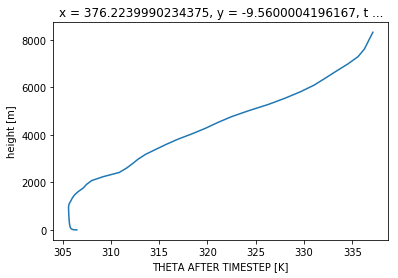

In [55]:
# integrate hydrostatic height, starting from z=0m (this is not strictly correct, 
# actual height above sealevel should ideally be used)
g = 9.81 #  [m/s^2]
# dp/dz = - rho g
dp = np.diff(ds.p)
rho_c = 0.5*(ds.rho[1:].values + ds.rho[:-1].values)

dz = - dp/(rho_c*g)
z = np.zeros_like(ds.p)
z[1:] += np.cumsum(dz)

ds['z'] = (ds.p.dims, z)
ds.z.attrs['long_name'] = 'height'
ds.z.attrs['units'] = 'm'

ds.swap_dims(dict(p='z')).theta.plot(y='z')

In [56]:
import tephigram

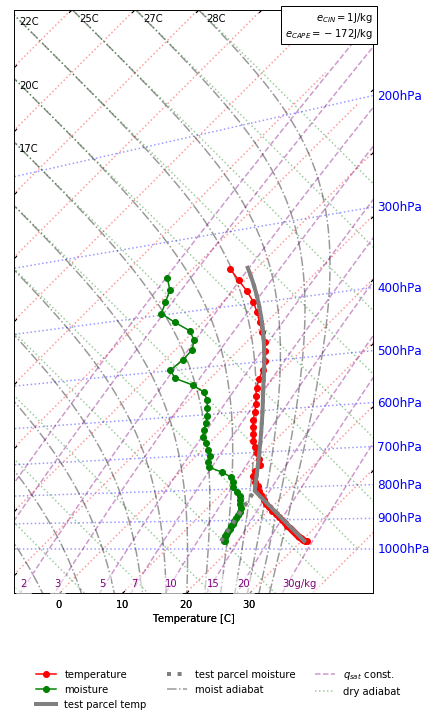

In [58]:
tphi = tephigram.Tephigram()
tphi.plot_temp(P=ds.p/100., T=ds.temp-273.15)
tphi.plot_RH(P=ds.p/100., T=ds.temp-273.15, RH=ds.rh/100)
# the tephigram package's parcel integration isn't ideal right now in that the starting values can't be specified
# we'll just bump the values here for now. In future I hope to improve on the tephigram package and
# include it in MetPy
tphi.plot_test_parcel(z=z, P=ds.p/100., T=ds.temp-273.15, RH=ds.rh/100., dT0=-0.5, dqv0=-0.0002)
tphi.plot_legend()

# Values along transect

In this section you will use the following skills:

1. Defining a new grid and regridding variables onto it
2. Calculate integral values, e.g. profile integrals like CAPE (Convectively Available Potential Temperature)

From the paper:

> Figure 9 illustrates the change in a number of model diagnostics along a southeast to northwest transect (shown by the straight lines in Figures 5–7) at 1100 UTC. This transect was designed to incorporate both the parent and daughter storm locations, as well as the wet patch at 16°N. The location of the parent storm in both the control and ASSIM simulations is between 11 and 13°N, which is shown by the model medium cloud fraction in Figure 9(a). This storm is precipitating and thus there is wet soil beneath it (Figure 9(b)). The region of wet soil produced by the MCS on the previous day is at 16°N. The soil moisture gradients are greater in the control run; the wet patch spans only ∼100 km, compared with more than 300 km in the ASSIM experiment. Moisture at the surface has a strong influence on the surface turbulent heat fluxes (Figure 9(c)). In the control run the sensible heat flux (H) is low over the wet soil patch at 16°N and higher over the drier soil to the north. The latent heat flux shows the opposite trend; it is higher over the wet patch at 16°N and lower over the drier soil. The fluxes in the ASSIM simulation are more similar across the soil‐moisture gradients; both the sensible and latent heat fluxes vary by less than 150 W m−2 over the wet and dry soil.

<img src='../figures/figure-9.jpg' width=500 />

**Figure 9: Variables at 1100 UTC, 31 July 2006 along the diagonal: (a) medium cloud fraction, (b) soil moisture in the uppermost layer, (c) surface sensible (H) and latent (E) heat fluxes, (d) surface (Ts) and near‐surface (T1.5m) temperatures, (e) near‐surface specific humidity, (f) 10 m wind speed, (g) convective available potential energy (CAPE), (h) convective inhibition (CIN). Solid lines represent diagnostics from the control and the dashed lines represent diagnostics from the ASSIM simulation. The vertical black line marks the position of the cold pool on the diagonal section. **

In [17]:
def search_files(s):
    "quick function to search through long names of output files to find which files contain variable"
    for l in "a c d f g h".split(" "):
        ds = xr.open_mfdataset('../data/UM/b223_case/xgifha_p{}005.nc'.format(l))
        for v in ds.data_vars:
            if s in ds[v].long_name.lower():
                print(l, ds[v].name, ds[v].long_name, ds[v].dims)
                
search_files('medium')
search_files('flux')
search_files('soil')
search_files('temp')
search_files('humid')
search_files('wind')
search_files('pres')

h field32 MEDIUM CLOUD AMOUNT ('t', 'unspecified', 'y', 'x')
g solar Net short wave radiation flux ('t', 'surface', 'y', 'x')
g longwave Net long wave radiation flux ('t', 'surface', 'y', 'x')
g sh Sensible heat flux ('t_1', 'surface', 'y', 'x')
g lh Latent heat flux ('t_1', 'surface', 'y', 'x')
g sm Total soil moisture content (levels 1-4) ('t_1', 'surface', 'y', 'x')
g sm_1 Soil moisture in each (of 4) levels ('t_1', 'level6', 'y', 'x')
c temp Temperature T ('t', 'p', 'y_1', 'x_1')
d theta Potential temperature ('t', 'hybrid_ht', 'y', 'x')
g temp Temperature T ('t_1', 'ht', 'y', 'x')
g temp_1 Temperature T ('t_1', 'surface', 'y', 'x')
d q Specific humidity q ('t', 'hybrid_ht', 'y', 'x')
g q Specific humidity q ('t_1', 'ht', 'y', 'x')
c u Westerly component of wind  u ('t', 'p', 'y', 'x')
c v Southerly component of wind v ('t', 'p', 'y', 'x')
f x-wind x wind component (with respect to grid) ('t', 'hybrid_ht', 'y', 'x')
f y-wind y wind component (with respect to grid) ('t', 'hybrid_ht'

In [55]:
def regrid_um_data(da, new_grid, method):
    """
    `new_grid` can either a float, representing the new grid-resolution in degrees, or a xr.Dataset
    containing the new grid
    """
    trnsfm = get_transform(da)

    try:
        pts = ccrs.PlateCarree().transform_points(trnsfm, *np.meshgrid(da.x, da.y))
        old_grid = xr.Dataset(coords=dict(x=da.x, y=da.y))
    except AttributeError:
        pts = ccrs.PlateCarree().transform_points(trnsfm, *np.meshgrid(da.x_1, da.y_1))
        old_grid = xr.Dataset(coords=dict(x=da.x_1, y=da.y_1))

    lon = pts[...,0]
    lat = pts[...,1]
        
    # we transpose lat and lon because xESMF prefers data to be fortran-ordered (instead of c-ordered)
    old_grid['lat'] = (('y', 'x'), np.ascontiguousarray(lat))
    old_grid['lon'] = (('y', 'x'), np.ascontiguousarray(lon))
    
    if type(new_grid) == float:
        d_deg = new_grid
    
        d_lat = d_lon = d_deg
        d_lat_min = np.diff(lat).max()
        d_lon_min = np.diff(lon).max()

        if d_lat < d_lat_min or d_lon < d_lon_min:
            raise Exception("Requested resolution `{}` is smaller than the coarsest resolution "
                            "in the input data (`{}` and `{}`)".format(d_deg, d_lat_min, d_lon_min))

        lat_new = np.arange(lat.min(), lat.max(), d_lat)
        lon_new = np.arange(lon.min(), lon.max(), d_lon)

        new_grid = xr.Dataset(coords=dict(lat=lat_new, lon=lon_new))
    
    regridder = xesmf.Regridder(ds_in=old_grid, ds_out=new_grid, method=method, reuse_weights=True)
    
    da_regridded = regridder(da)
    # copy over attributes
    da_regridded.attrs.update(da.attrs)
    # but remove the rotate grid info
    del(da_regridded.attrs['north_pole'])
    # xarray 
    
    return da_regridded

In [53]:
# define lat/lon of cross-section endpoints
p0 = [17, 0]  # (lat, lon)
p1 = [11, 5]  # (lat, lon)

# define new grid, have for example 100 points along cross-section
Nx = 100
i = range(Nx)
j = range(1)
new_grid = xr.Dataset(coords=dict(i=i, j=j))

new_grid['lat'] = (('i', 'j'), np.array([np.linspace(p0[0], p1[0], Nx),]).T)
new_grid['lon'] = (('i', 'j'), np.array([np.linspace(p0[1], p1[1], Nx),]).T)

new_grid

<xarray.Dataset>
Dimensions:  (i: 100, j: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0
Data variables:
    lat      (i, j) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
    lon      (i, j) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...

In [114]:
# store reference to which file each variable that we need is stored in
variables = [
    ('h', 'field32'),
    ('g', 'sm'),
    ('g', 'sh'),
    ('g', 'lh'),
    ('g', 'temp'), # surface temperature
    ('g', 'q'), # surface specific moisture
    ('c', 'temp'),
    ('c', 'u'),
    ('c', 'v'),
]
time_group = 0

ds_cross_section = xr.Dataset(coords=new_grid.coords)

for file_group, var_name in variables:
    ds = xr.open_mfdataset('../data/UM/b223_case/xgifha_p{}0{:02d}.nc'.format(file_group, time_group))
    da = ds[var_name]

    da_regridded = regrid_um_data(da=da, new_grid=new_grid, method='bilinear')
    t_dim = da_regridded.dims[0]  # time dimension is first dimension
    
    if var_name == 'temp':
        if 'surface' in da_regridded.dims:
            da_regridded.name = "{}_surf".format(da_regridded.name)
    ds_cross_section[da_regridded.name] = da_regridded.rename(**{t_dim: "time"})
    
ds_cross_section = ds_cross_section.squeeze('j') # remove the dimension perpendicular to the cross section's plane
ds_cross_section = ds_cross_section.swap_dims(dict(i='lat')) # swap the along cross-section dimension for latitude
ds_cross_section

Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_776x1110_100x1.nc
Reuse existing file: bilinear_775x1110_100x1.nc
Reuse existing file: bilinear_775x1110_100x1.nc


<xarray.Dataset>
Dimensions:      (ht_1: 1, lat: 100, p: 7, surface: 1, time: 12, unspecified: 1)
Coordinates:
    i            (lat) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    j            int64 0
  * time         (time) datetime64[ns] 2006-07-31T06:04:59.998855590 ...
    lon          (lat) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...
  * lat          (lat) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
  * unspecified  (unspecified) float32 -1.0
  * surface      (surface) float32 0.0
  * ht_1         (ht_1) float32 -1.0
  * p            (p) float32 925.0 850.0 700.0 600.0 500.0 400.0 200.0
Data variables:
    field32      (time, unspecified, lat) float64 2.901e-06 7.465e-07 ...
    sm           (time, surface, lat) float64 -25.65 -38.5 -48.74 -58.4 ...
    sh           (time, surface, lat) float64 -2.625 -10.3 -21.09 -25.96 ...
    lh           (time, surface, lat) float64 1.953 2.07 0.02398 0.002649 ...
    temp_surf    (time, surface, lat) f

In [115]:
ds_cross_section['u_mag'] = np.sqrt(ds_cross_section.u**2. + ds_cross_section.v**2.)
ds_cross_section.u_mag.attrs['units'] = ds_cross_section.u.units
ds_cross_section.u_mag.attrs['long_name'] = 'wind speed'

[Text(0.5,1,''), Text(0.5,1,''), Text(0.5,1,''), Text(0.5,1,'')]

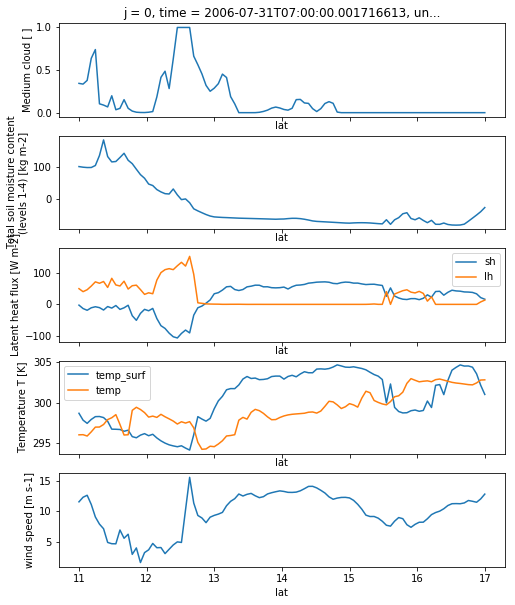

In [116]:
fig, axs = plt.subplots(ncols=1, nrows=5, sharex=True, figsize=(8, 10))

ds_ = ds_cross_section.sel(time='2006-07-31 12:00', method='nearest').squeeze()

ds_.field32.plot(ax=axs[0])

ds_.sm.plot(ax=axs[1])

ds_.sh.plot(ax=axs[2])
ds_.lh.plot(ax=axs[2])
axs[2].legend()
axs[2].set_ylim(-120, 180)

ds_.temp_surf.plot(ax=axs[3])
ds_.temp.sel(p=1000, method='nearest').plot(ax=axs[3])
axs[3].legend()

ds_.u_mag.sel(p=1000, method='nearest').plot(ax=axs[4])

[ax.set_title("") for ax in axs[1:]]

# Regridding ERA-Interim data

Below are examples of regridding, but working on ERA-Interim data instead of the Unified Model data output.

### Along existing grid

In [11]:
# extracting a long a longitude is easy
ds_ = ds_ei.sel(time='2006-07-31 12:00').sel(latitude=20, method='nearest')

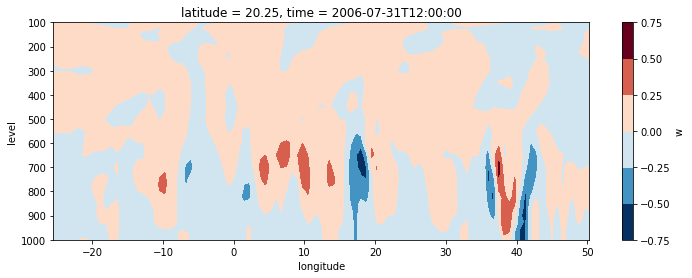

In [12]:
ds_.w.plot.contourf(yincrease=False, size=4, aspect=3)

### Not along existing grid

Definining new grid:

In [13]:
# define lat/lon of cross-section endpoints
p0 = [17, 0]  # (lat, lon)
p1 = [11, 5]  # (lat, lon)

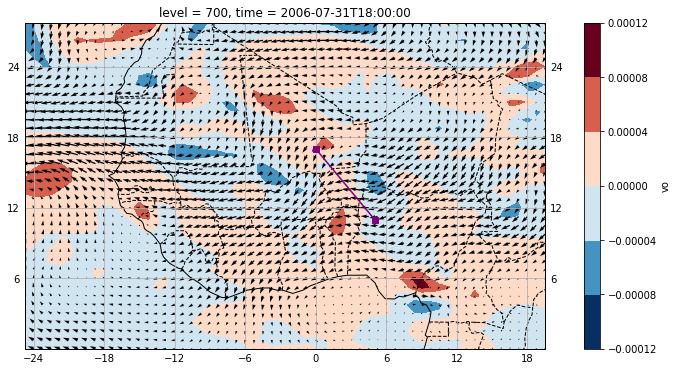

In [15]:
# plot cross-section endpoints to ensure they are in the correct place

fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(projection=ccrs.PlateCarree())

ds_ = ds_ei.sel(level=700, time='2006-07-31 18:00', longitude=slice(-25, 20), latitude=slice(28, 0))

ds_.vo.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
plt.quiver(*np.meshgrid(ds_.longitude, ds_.latitude, indexing='xy'), u=ds_.u, v=ds_.v)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False

plt.plot([p0[1], p1[1]], [p0[0], p1[0]], linestyle='-', marker='s', color='purple')

In [16]:
# define new grid, have for example 100 points along cross-section
Nx = 100
Nz = len(ds_ei.level)
i = range(Nx)
j = range(1)
k = range(Nz)
ds_grid = xr.Dataset(coords=dict(i=i, j=j, k=k))

ds_grid['lat'] = (('i', 'j'), np.array([np.linspace(p0[0], p1[0], Nx),]).T)
ds_grid['lon'] = (('i', 'j'), np.array([np.linspace(p0[1], p1[1], Nx),]).T)
ds_grid['level'] = (('k'), ds_ei.level)

ds_grid

<xarray.Dataset>
Dimensions:  (i: 100, j: 1, k: 27)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    lat      (i, j) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
    lon      (i, j) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...
    level    (k) int32 100 125 150 175 200 225 250 300 350 400 450 500 550 ...

In [17]:
ds_oldgrid = xr.Dataset()
ds_oldgrid['level'] = ds_ei.level
ds_oldgrid['lat'] = ds_ei.latitude
ds_oldgrid['lon'] = ds_ei.longitude

ds_oldgrid

<xarray.Dataset>
Dimensions:    (latitude: 68, level: 27, longitude: 102)
Coordinates:
  * level      (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
  * latitude   (latitude) float32 45.0 44.25 43.5 42.75 42.0 41.25 40.5 ...
  * longitude  (longitude) float32 -25.5 -24.75 -24.0 -23.25 -22.5 -21.75 ...
Data variables:
    lat        (latitude) float32 45.0 44.25 43.5 42.75 42.0 41.25 40.5 ...
    lon        (longitude) float32 -25.5 -24.75 -24.0 -23.25 -22.5 -21.75 ...

In [25]:
# create regridder instance for transforming between old and new grid
regridder = xesmf.Regridder(ds_in=ds_oldgrid, ds_out=ds_grid, method='bilinear')

Overwrite existing file: bilinear_68x102_100x1.nc 
 You can set reuse_weights=True to save computing time.


In [26]:
# select timestep of interest and call regridder on each field of interest
ds_ = ds_ei.sel(time="2006-07-31 12:00")
ds_ei_transect = xr.Dataset()
ds_ei_transect['w'] = regridder(ds_.w)
ds_ei_transect['t'] = regridder(ds_.t)

# remove extra dimension (I called it `j`) perpendicular to cross-section plane
ds_ei_transect = ds_ei_transect.squeeze()
ds_ei_transect

<xarray.Dataset>
Dimensions:  (i: 100, level: 27)
Coordinates:
    lon      (i) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 0.3535 ...
    lat      (i) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 16.52 ...
    time     datetime64[ns] 2006-07-31T12:00:00
  * level    (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
Dimensions without coordinates: i
Data variables:
    w        (level, i) float64 0.003443 0.003623 0.003821 0.004038 0.004272 ...
    t        (level, i) float64 196.3 196.3 196.2 196.2 196.2 196.1 196.1 ...

In [27]:
ds_ei_transect['lat'] = (('i',), ds_ei_transect.lat)
ds_ei_transect = ds_ei_transect.swap_dims(dict(i='lat'))
ds_ei_transect

<xarray.Dataset>
Dimensions:  (lat: 100, level: 27)
Coordinates:
    lon      (lat) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...
  * lat      (lat) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
    time     datetime64[ns] 2006-07-31T12:00:00
  * level    (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
Data variables:
    w        (level, lat) float64 0.003443 0.003623 0.003821 0.004038 ...
    t        (level, lat) float64 196.3 196.3 196.2 196.2 196.2 196.1 196.1 ...

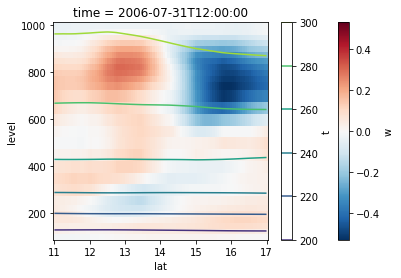

In [30]:
ds_ei_transect.w.plot()
ds_ei_transect.t.plot.contour(add_colorbar=True)